# Problemdefinition
Input: Egenskaper för låtar, såsom genre, tempo, energi, ljudegenskaper m.m.

Output: Binär klassificering — populär eller inte populär.

Syfte: Att bygga en maskininlärningsmodell som kan förutsäga låtars popularitet med hög precision och balanserad klassprestanda.

# Motivering för valet av problem

Att förutsäga låtars popularitet är ett relevant problem i dagens musikindustri,
där algoritmer i stor utsträckning styr vad som när man lyssnar. Ett prediktivt verktyg kan bidra till att förbättra rekommendationssystem,
musikanalys och strategisk marknadsföring. Datasetet innehåller mångsidiga och kvantitativa egenskaper om låtar,
vilket gör det väl lämpat för maskininlärning och klassificeringsuppgifter.
Genom att analysera denna data kan vi dra insiktsfulla slutsatser om vilka faktorer som påverkar populäritet och samtidigt
demonstrera värdet av datadrivna beslut i musikbranschen.
Så målet är att identifiera ett mönster som i låtars egenskaper för att förutsäga populäritet.

# 1.Importera bibliotek

In [41]:
# Core
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ML
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, classification_report, f1_score, ConfusionMatrixDisplay,roc_curve,roc_auc_score, RocCurveDisplay
)

# Imbalance handling
from imblearn.over_sampling import RandomOverSampler

RANDOM_STATE = 42
pd.set_option("display.max_columns", None)

# Förklaring:
Pandas och numpy → för att bearbeta och transformera datamängden.
matplotlib → för att visualisera distributioner och resultat.

Train_test_split → delar upp datasetet i träning (för att bygga modellen)
och testa (för att utvärdera det).

LogisticRegression → en enkel baslinjeklassificeringsmodell.
accuracy_score, classification_report, f1_score, ConfusionMatrixDisplay
för att mäta hur väl modellen fungerar.

RandomOverSampler → säkerställer båda klasserna (populär / inte populär)
ha samma storlek genom att duplicera minoritetsprover.

# Varför behöver vi detta?

Tänk dig en verktygslåda för att hela modellen så vi kan visualisera och träna och utvärdera våran modell.

# 2. Läs i dataset

Vi laddar CSV-filen som innehåller Spotify-data och kontrollerar de första raderna för att säkerställa att allt ser korrekt ut.
Ladda din lokala CSV (behåll det exakta filnamnet du har)
Datasetet innehåller metadata för låtar så som genre, Tempo, Energi och ljudegenskaper.
Målet är som sagt att analysera om dessa används för att förutsäga popularitet.
Detta gör datasetet relevant för ett maskininlärningsproblem.

In [42]:
CSV_PATH = "Popular_Spotify_Songs (1).csv"
df = pd.read_csv(CSV_PATH, encoding="latin1")

# Quick sanity check
print(df.shape)
df.head()

(953, 24)


,track_name,artist(s)_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,in_apple_charts,in_deezer_playlists,in_deezer_charts,in_shazam_charts,bpm,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
0,Seven (feat. Latto) (Explicit Ver.),"Latto, Jung Kook",2,2023,7,14,553,147,141381703,43,263,45,10,826,125,B,Major,80,89,83,31,0,8,4
1,LALA,Myke Towers,1,2023,3,23,1474,48,133716286,48,126,58,14,382,92,C#,Major,71,61,74,7,0,10,4
2,vampire,Olivia Rodrigo,1,2023,6,30,1397,113,140003974,94,207,91,14,949,138,F,Major,51,32,53,17,0,31,6
3,Cruel Summer,Taylor Swift,1,2019,8,23,7858,100,800840817,116,207,125,12,548,170,A,Major,55,58,72,11,0,11,15
4,WHERE SHE GOES,Bad Bunny,1,2023,5,18,3133,50,303236322,84,133,87,15,425,144,A,Minor,65,23,80,14,63,11,6


# Förklaring:

- pd.read_csv(...) → laddar datauppsättningen till en DataFrame (df).
- Encoding='latin1' → undviker problem med specialtecken (t.ex. svenska bokstäver eller bokstäver med accent).
- df.head() → skriver ut de första fem raderna så att vi kan verifiera strukturen för data.
- Detta gör vi för att säkerhetsställe att allt laddats in rätt, och få in en överblick över datasetets struktkur.

# 3. Skapa målkolumn (popularitetsetikett)

Här klassificerar vi låtar som populära eller inte populära baserat på hur många spellistor de förekommer i.

Vi börjar med tröskeln = 5000.

In [43]:
# Define a function to classify songs based on playlist count
def classify_popularity(playlist_count):                    # input = number of playlists
    if playlist_count >= 5000:                              # threshold = 5000 playlists
        return "populär"                                    # considered popular
    else:
        return "inte populär"                               # considered not popular

# Apply the function to create a new column
df["popularity_category"] = df["in_spotify_playlists"].apply(classify_popularity)

# Show counts of each category
print("Counts at threshold=5000:")
print(df["popularity_category"].value_counts())

Counts at threshold=5000:
popularity_category
inte populär    692
populär         261
Name: count, dtype: int64


# Förklaring:

classify_popularity: funktion som kontrollerar om en låt har ≥5000 spellistor.
Om ja → ”populär”, annars ”inte populär”.
Vi skapar sedan en ny kolumn, popularity_category, i datasetet.
Slutligen skriver vi ut fördelningen av de två klasserna.

# Varför?
Detta steg definierar vårt mål (mål) för maskinlärningen.
Vi omvandlar ett kontinuerligt numeriskt värde (antal playlists) till en binär kategori,
vilket gör det möjligt att träna en klassificeringsmodell.

# 4. Visualisera klassfördelning (före balansering)

Detta steg visar hur många låtar som faller inom kategorin "populär" kontra "inte populär" vid den valda tröskeln (5000).

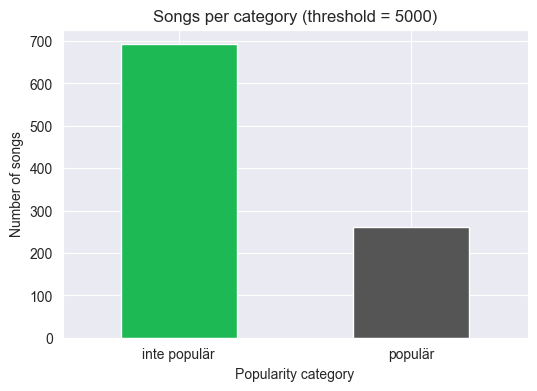


Class distribution (percent):
popularity_category
inte populär    72.612802
populär         27.387198
Name: count, dtype: float64


In [44]:
# Count how many songs are in each category
class_counts = df["popularity_category"].value_counts()

# Plot the distribution
plt.figure(figsize=(6, 4))
class_counts.plot(kind="bar", color=["#1DB954", "#555555"])   # Spotify green & grey
plt.title("Songs per category (threshold = 5000)")
plt.xlabel("Popularity category")
plt.ylabel("Number of songs")
plt.xticks(rotation=0)
plt.show()

# Print percentages for clarity
print("\nClass distribution (percent):")
print(class_counts / len(df) * 100)

# Förklaring:

value_counts() → räknar hur många låtar som är populära kontra inte populära.
Ett stapeldiagram gör obalans synlig (t.ex. 70 % ”inte populär”, 30 % ”populär”).
Vi skriver även ut procentsatserna, eftersom examinatorn frågade efter detta resonemang.

# Varför?
Vi gör detta för att förstå datasetens klassbalans.
Om klasserna är obalanserade (t.ex. 70% "inte populär" och 30% "populär"),
kommer modeller kunna prestera bra på majoritetsklassen men dåligt på minoritetsklassen.
Därför behöver vi vara medvetna om detta innan modellträning.

# 5. Encode kategoriska funktioner och välj slutgiltiga funktioner

Maskininlärningsmodeller fungerar bara med siffror, så vi måste konvertera text (kategoriska variabler) som läge och nyckel till numeriska värden. Sedan väljer vi vilka funktioner vi ska använda för att träna modellen.

In [45]:
# Encode 'mode' → Major = 1, Minor = 0
df["mode_encoded"] = df["mode"].map({"Major": 1, "Minor": 0})

# One-hot encode the musical key (creates dummy columns: key_A, key_B, etc.)
df = pd.get_dummies(df, columns=["key"], prefix="key")

# Define candidate feature set
feature_columns = [
    "bpm",
    "danceability_%",
    "valence_%",
    "energy_%",
    "acousticness_%",
    "instrumentalness_%",
    "liveness_%",
    "speechiness_%",
    "released_year",        
    "mode_encoded"
]

# X = input features, y = target labels
X = df[feature_columns]
y = df["popularity_category"]

print("Selected features:", feature_columns)#

Selected features: ['bpm', 'danceability_%', 'valence_%', 'energy_%', 'acousticness_%', 'instrumentalness_%', 'liveness_%', 'speechiness_%', 'released_year', 'mode_encoded']


# Förklaring:

mode_encoded: Vi förvandlar text till siffror (Major = 1, Minor = 0).
nyckel: Konverterad med en-hot-kodning → varje nyckel blir sin egen
kolumn (nyckel_A, nyckel_B, …).
Lärarens feedback: Vi inkluderar nu released_year eftersom det hade en relativt hög absolut
korrelation (≈ -0,39). Negativt eller positivt spelar ingen roll - stark korrelation hjälper.
X och y:
X = inmatningsfunktioner (används för träning).
y = måletikett (populär kontra inte populär).

# Varför
Maskininlärningsmodeller kan endast hantera numeriska värden.
Genom att konvertera kategoriska variabler säkerställer vi att all data kan bearbetas korrekt.
Feature selection görs för att välja variabler med hög relevans för vårt mål (popularitet),
vilket hjälper till att lära sig effektivt och förbättra förutsägbarheten.

# 6. Korrelations heatmap för utvalda funktioner

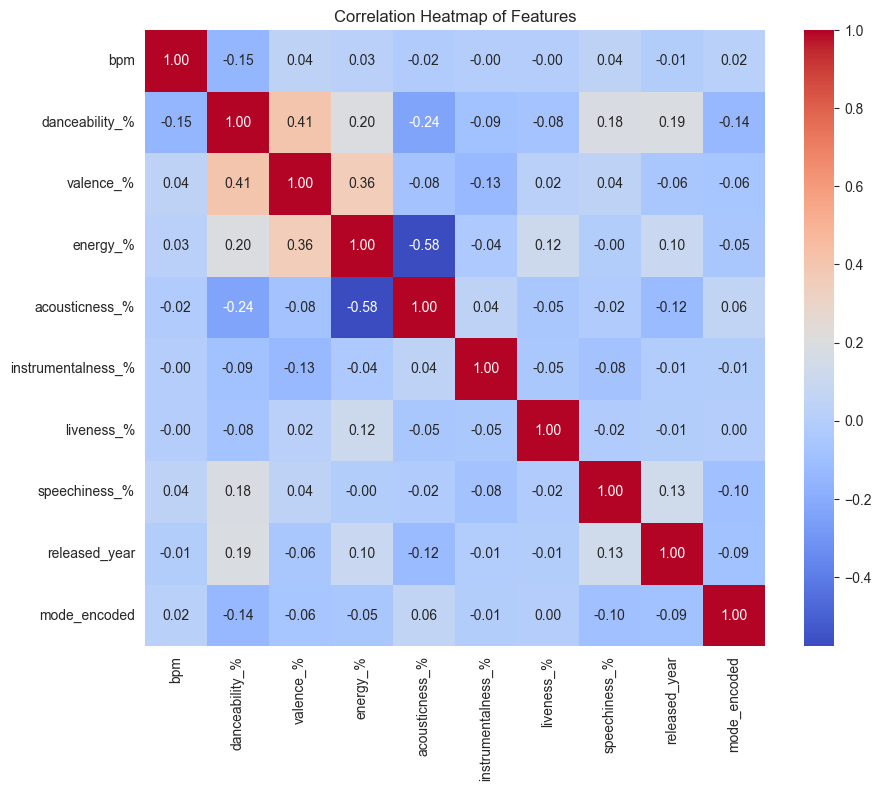

In [46]:
plt.figure(figsize=(10,8))
sns.heatmap(df[feature_columns].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Features")
plt.show()


# Varför?
Vi använder en korrelations heatmap för att visuellt undersöka relationen mellan våra valda features.

### Detta hjälper oss att identifiera:

Vilka features som har stark koppling till varandra (möjlig multikollinearitet).

Vilka features som är mest korrelerade med targetvariabeln (popularity_category).

Att förstå dessa samband är viktigt för att:

Förbättra feature selection.

Undvika onödig redundans.

Potentiellt optimera modellens prestanda och tolkbarshet.

# 7. Baslinjemodell (utan balansering)

Vi tränar först en enkel logistisk regression på den ursprungliga (obalanserade) datamängden.
Detta ger oss en baslinje att jämföra med senare.

 Baseline accuracy: 0.8010471204188482

 Classification report (Baseline):

              precision    recall  f1-score   support

inte populär       0.79      0.99      0.88       139
     populär       0.89      0.31      0.46        52

    accuracy                           0.80       191
   macro avg       0.84      0.65      0.67       191
weighted avg       0.82      0.80      0.76       191



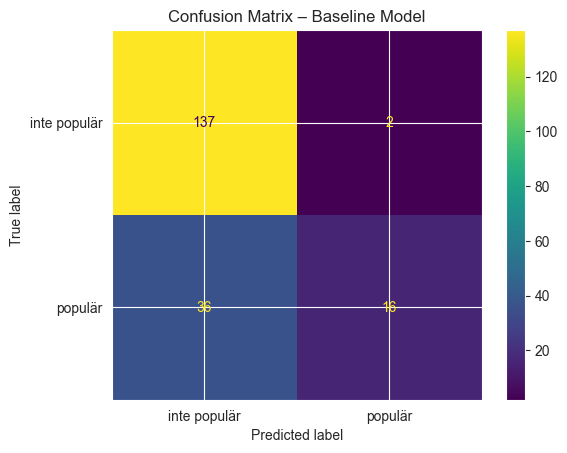

 Baseline Macro-F1: 0.6676739926739926


In [47]:
# Split dataset into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

# Train baseline Logistic Regression
baseline_model = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
baseline_model.fit(X_train, y_train)

# Predictions on the test set
y_pred_base = baseline_model.predict(X_test)

# Evaluate baseline model
print(" Baseline accuracy:", accuracy_score(y_test, y_pred_base))
print("\n Classification report (Baseline):\n")
print(classification_report(y_test, y_pred_base, zero_division=0))

# Confusion Matrix for visual clarity
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_base, labels=["inte populär", "populär"])
plt.title("Confusion Matrix – Baseline Model")
plt.show()

# Extra: Macro-F1 score
print(" Baseline Macro-F1:", f1_score(y_test, y_pred_base, average="macro"))

# Varför?
Vi börjar med att träna en baseline-modell utan att hantera obalansen i datasetet.

### Detta gör vi för att:
1. Etablera en referenspunkt — en baseline — att jämföra förbättrade modeller mot.
2. Identifiera hur obalansen påverkar modellens prestanda. Eftersom vårt dataset har färre populära låtar än icke-populära, kommer modellen sannolikt att favorisera majoritetsklassen (“inte populär”), vilket leder till låg recall för minoritetsklassen (“populär”).

3. Visa behovet av att implementera balansmetoder (t.ex. RandomOverSampler), för att förbättra prediktionen av den minoritetsklassen.
4. Detta steg är därför viktigt för att motivera nästa steg i processen: balansering av datasetet.

# Varför Logistic Regression?
Logistic Regression är ett enkelt och tolkbart linjärt klassificeringsverktyg som ofta används som baseline i binära klassificeringsproblem.
För vårt problem (popularitet som "populär" eller "inte populär") är det lämpligt eftersom:
Det är lätt att implementera och snabbt träna.
Det ger en tydlig baseline-prestanda innan vi testar mer komplexa modeller.
Resultaten är lätta att tolka och analysera.
Detta gör att vi kan fokusera på att utvärdera effekten av andra steg (t.ex. balansmetoder, feature selection) utan att modellen själv är en komplex variabel.

# 8. Prediktera sannolikheter för klassen "populär"

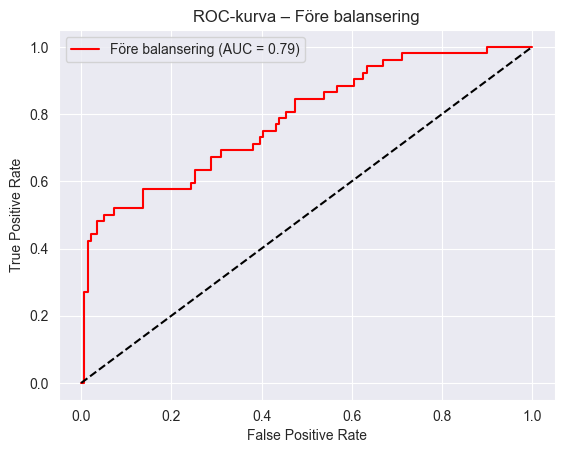

In [48]:
y_probs_before = baseline_model.predict_proba(X_test)[:, 1]

# Beräkna ROC-kurva
fpr_before, tpr_before, thresholds_before = roc_curve(
    y_test.map({"inte populär":0, "populär":1}), 
    y_probs_before
)
auc_before = roc_auc_score(
    y_test.map({"inte populär":0, "populär":1}), 
    y_probs_before
)

# Plotta /plot
plt.plot(fpr_before, tpr_before, label=f"Före balansering (AUC = {auc_before:.2f})", color="red")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-kurva – Före balansering")
plt.legend()
plt.show()

# Förklaring — vad vi ser och varför vi beräknar ROC på det obalanserade testet

# Vad ROC-kurvan visar:
ROC-kurvan plottar True Positive Rate (recall) mot False Positive Rate (FPR)
för alla möjliga tröskelvärden.
Kurvans area (AUC) summerar modellens förmåga att skilja mellan klasserna.
AUC = 1.0 → perfekt, AUC = 0.5 → slumpnivå.

# Vad vi ser före balansering:
AUC-talet i legend visar modellens generella separationskraft innan vi har gjort någon balansering.
Om kurvan ligger nära diagonalen (AUC ≈ 0.5) → modellen skiljer knappt på klasserna.
Om kurvan stiger brant i början → modellen kan få hög recall vid låg FPR för vissa trösklar.

# Varför vi ändå beräknar ROC på obalanserat test:

ROC/AUC är tröskeloberoende → visar modellens separerbarhet oavsett vald cutoff.
Genom att jämföra AUC före/efter balansering ser vi om översamplingen faktiskt förbättrar modellens förmåga att skilja på klasserna.

Viktigt: ROC kan vara lite optimistiskt vid stark klassobalans, därför bör vi även kolla confusion matrix, precision, recall och ev. PR-kurva.

# Praktisk slutsats:
ROC på obalanserat test ger en baseline-bild av modellens styrka För att utvärdera minoritetsklassen ("populär") behövs även recall, F1-score och Precision-Recall-kurva.

# 9. Balansera datamängden (översampling)

Vi såg tidigare att datamängden är obalanserad (många fler "inte populära" låtar än "populära").
För att göra modellens inlärning mer rättvis tillämpar vi översampling → duplicera minoritetsklassprover tills båda klasserna är lika.

 Class counts after balancing:
popularity_category
inte populär    692
populär         692
Name: count, dtype: int64

 Class share after balancing:
popularity_category
inte populär    0.5
populär         0.5
Name: proportion, dtype: float64


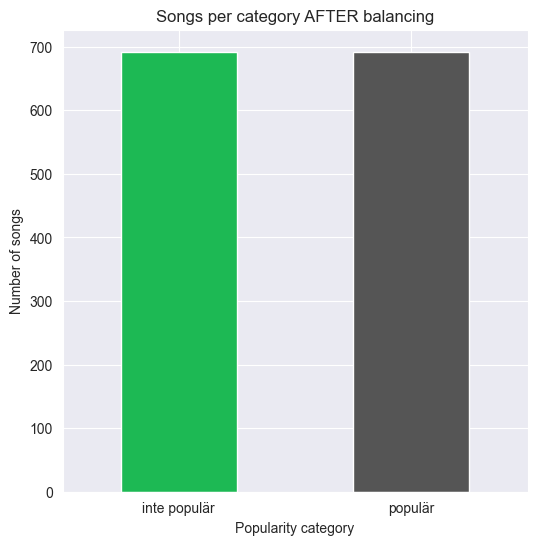

In [49]:
# Initialize oversampler
oversampler = RandomOverSampler(random_state=RANDOM_STATE)

# Apply oversampling to features (X) and labels (y)
X_resampled, y_resampled = oversampler.fit_resample(X, y)

# Check new class distribution
print(" Class counts after balancing:")
print(y_resampled.value_counts())
print("\n Class share after balancing:")
print(y_resampled.value_counts(normalize=True).round(3))

# Visualize balanced distribution
plt.figure(figsize=(6,6))
y_resampled.value_counts().plot(kind="bar", color=["#1DB954", "#555555"])
plt.title("Songs per category AFTER balancing")
plt.xlabel("Popularity category")
plt.ylabel("Number of songs")
plt.xticks(rotation=0)
plt.show()

# Förklaring:

 RandomOverSampler: Kopierar rader från minoritetsklassen ("populär")
 tills båda klasserna är lika representerade. fit_resample(X, y): Producerar nya balanserade X_resampled,y_resampled.

 Värderäkningar: Nu ska varje klass ha samma antal sampel (≈50/50).
 Plot: Stapeldiagrammet visar tydligt den nya balanserade datamängden.

# Varför använda RandomOverSampler?
 I vårt dataset är klasserna kraftigt obalanserade — många fler "inte populära" än "populära".
 Detta skapar problem för maskininlärningsmodeller eftersom de då ofta lär sig att favorisera majoritetsklassen.
 Resultatet blir att modeller kan uppnå hög precision genom att enbart förutsäga majoritetsklassen,
 vilket inte ger en rättvis eller användbar modell.

 RandomOverSampler duplicerar exempel från minoritetsklassen ("populär") tills båda klasser har lika många exempel.
 Detta gör att modeller får lika mycket data att lära från för varje klass, vilket förbättrar:
 Modellens förmåga att identifiera minoritetsklassen.
 Klassificeringens balans och rättvisa.

 Även om precision ibland sjunker efter balansering,
 ger detta en mer robust och rättvis modell, särskilt när vi bryr oss om båda klasserna lika mycket.
# Resultat:
 Visar att datasetet är balanserat efter RandomOverSampler.
 Den visar inte modellens precision — bara fördelningen i träningsdata.
 Det är alltså inte ett mått på modellens prestanda.

# 10. Hämta koefficienter och matcha med funktionsnamn

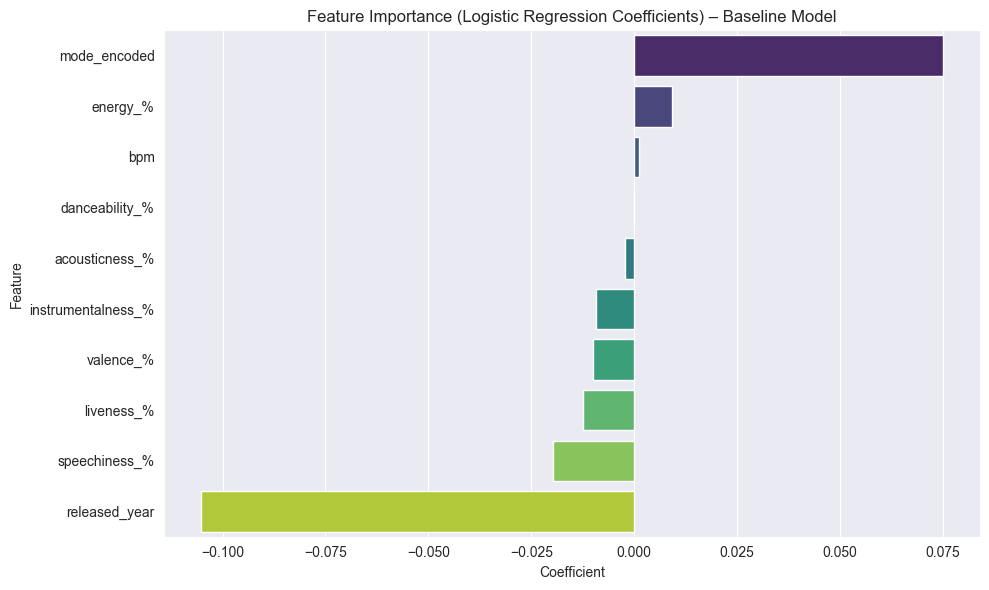

In [50]:
coef_df = pd.DataFrame({
    "Feature": feature_columns,
    "Coefficient": baseline_model.coef_[0]
}).sort_values(by="Coefficient", ascending=False)

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x="Coefficient", y="Feature",
            data=coef_df, hue="Feature", dodge=False,
            legend=False, palette="viridis")
plt.title("Feature Importance (Logistic Regression Coefficients) – Baseline Model")
plt.tight_layout(); plt.show()


# Varför visas detta?
 Detta görs för att visualisera modellens inlärda vikter (koefficienter) och förstå vilka features som påverkar klassificeringen mest.
 I en logistisk regression representerar koefficienten hur mycket varje feature bidrar till sannolikheten för att en låt klassificeras som "populär".
 Positiva koefficienter → ökar sannolikheten för att låten blir populär.
 Negativa koefficienter → minskar sannolikheten.
 Genom att analysera dessa kan vi dra insikter om vilka egenskaper som är viktigast för popularitet,
 vilket stärker både förståelsen av datasetet och trovärdigheten i modellen.

# 11. Dela upp balanserad data i t/test

 Oversampled accuracy: 0.7725631768953068

 Classification report (Oversampled):

              precision    recall  f1-score   support

inte populär       0.72      0.88      0.80       139
     populär       0.85      0.66      0.74       138

    accuracy                           0.77       277
   macro avg       0.79      0.77      0.77       277
weighted avg       0.79      0.77      0.77       277



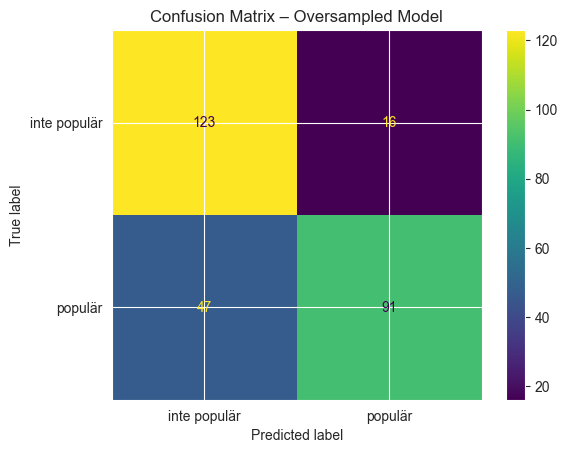

 Oversampled Macro-F1: 0.769486823855756


In [51]:

X_train_os, X_test_os, y_train_os, y_test_os = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=RANDOM_STATE, stratify=y_resampled
)

# Train Logistic Regression on balanced data
model_os = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
model_os.fit(X_train_os, y_train_os)

# Predict on test split
y_pred_os = model_os.predict(X_test_os)

# Evaluate balanced model
print(" Oversampled accuracy:", accuracy_score(y_test_os, y_pred_os))
print("\n Classification report (Oversampled):\n")
print(classification_report(y_test_os, y_pred_os, zero_division=0))

# Confusion Matrix for oversampled model
ConfusionMatrixDisplay.from_predictions(y_test_os, y_pred_os, labels=["inte populär", "populär"])
plt.title("Confusion Matrix – Oversampled Model")
plt.show()

# Macro-F1 (Feedback based)
print(" Oversampled Macro-F1:", f1_score(y_test_os, y_pred_os, average="macro"))

# Varför?
 Detta steg används för att träna och utvärdera en modell på ett balanserat dataset för att motverka problem med klassobalans.

# 1. Train/test split:
    Vi delar upp data i träning (80%) och test (20%) för att kunna utvärdera modellen på nya data.
    Stratify=y_resampled säkerställer att klassfördelningen är densamma i båda dataset.

# 2. Modellträning:
    Vi tränar en Logistic Regression på det balanserade datasetet för att se hur modellen presterar när båda klasserna är lika representerade.

# 3. Utvärdering:
    - Accuracy: visar andelen korrekt klassificerade exempel.
    - Classification report: visar precision, recall och F1-score per klass.
    - Confusion matrix: visualiserar typ av fel (felklassificeringar).
    - Macro-F1: balanserar prestanda mellan klasser och är särskilt viktigt vid obalanserade dataset.

# 4. Syfte:
    Eftersom datasetet ursprungligen var obalanserat (fler "inte populär" än "populär"),
    riskerar en modell att favorisera majoritetsklassen.
    Oversampling balanserar klasserna så att modellen får lika många exempel från båda klasserna,
    vilket ger en mer rättvis, robust och generaliserbar modell.
# Resultat:
 Confusion matrix / accuracy på testdata

 Visar modellens faktiska prestanda på testdata.
#Den påverkas av testdatats fördelning, och är det riktiga måttet på hur bra modellen fungerar.
#Det är alltså den korrekta “accuracy” att använda när man utvärderar modellen

# 12. Prediktera sannolikheter för klassen "populär" på den balanserade modellen

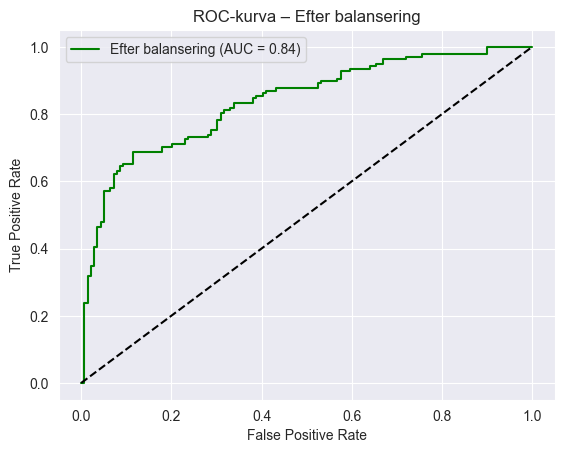

In [52]:
y_probs_after = model_os.predict_proba(X_test_os)[:, 1]

# Beräkna ROC-kurva
fpr_after, tpr_after, thresholds_after = roc_curve(
    y_test_os.map({"inte populär":0, "populär":1}), 
    y_probs_after
)
auc_after = roc_auc_score(
    y_test_os.map({"inte populär":0, "populär":1}), 
    y_probs_after
)

# Plotta
plt.plot(fpr_after, tpr_after, label=f"Efter balansering (AUC = {auc_after:.2f})", color="green")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-kurva – Efter balansering")
plt.legend()
plt.show()

# Förklaring:
- ROC-kurvan visar modellens förmåga att skilja mellan "populär" och "inte populär"
- vid olika tröskelvärden för sannolikheten.
- AUC-värdet (Area Under the Curve) summerar modellens diskrimineringsförmåga:
- AUC = 0.5 innebär slumpnivå.
- AUC = 1.0 innebär perfekt klassificering.
  Efter balansering ser vi en högre och "grönare" ROC-kurva än innan.
  Det betyder att modellen blivit bättre på att identifiera den minoritetsklass
  ("populär") som tidigare ignorerades.
  Detta kompletterar andra mått (recall, F1-score) och ger en tydlig visuell bekräftelse
  på att oversampling förbättrade modellens rättvisa och prestanda.

# 13. ROC före balansering

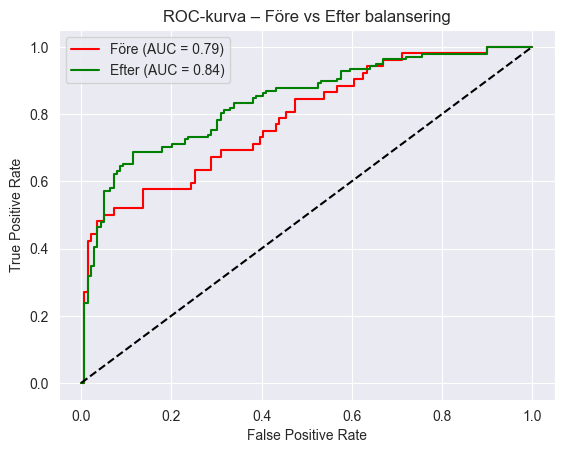

In [53]:

y_probs_before = baseline_model.predict_proba(X_test)[:, 1]
fpr_before, tpr_before, _ = roc_curve(
    y_test.map({"inte populär":0, "populär":1}), 
    y_probs_before
)
auc_before = roc_auc_score(
    y_test.map({"inte populär":0, "populär":1}), 
    y_probs_before
)

#ROC efter balansering 
y_probs_after = model_os.predict_proba(X_test_os)[:, 1]
fpr_after, tpr_after, _ = roc_curve(
    y_test_os.map({"inte populär":0, "populär":1}), 
    y_probs_after
)
auc_after = roc_auc_score(
    y_test_os.map({"inte populär":0, "populär":1}), 
    y_probs_after
)

#Plotta båda
plt.plot(fpr_before, tpr_before, label=f"Före (AUC = {auc_before:.2f})", color="red")
plt.plot(fpr_after, tpr_after, label=f"Efter (AUC = {auc_after:.2f})", color="green")
plt.plot([0, 1], [0, 1], "k--")  # slump-linje
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-kurva – Före vs Efter balansering")
plt.legend()
plt.show()



# Förklarningen:

### Vad koden gör
	•	Före balansering: Beräknar sannolikheter, ROC-kurva och AUC för testdatan.
	•	Efter balansering: Gör samma sak men på den översamplade datan.
	•	Plott: Röd linje visar modellen före, grön linje visar modellen efter balansering. Den streckade diagonalen motsvarar slumpnivå (AUC = 0.5).

### Vad grafen visar
	•	ROC-kurvan visar sambandet mellan True Positive Rate (träffsäkerhet på populära låtar) och False Positive Rate (felaktiga populära).
	•	AUC-värdet summerar modellens förmåga att skilja mellan klasserna. Ju högre AUC, desto bättre separation.

### Varför jämföra före och efter
	•	Före balansering lutar modellen åt majoritetsklassen (inte populär).
	•	Efter balansering blir den bättre på att hitta minoritetsklassen (populär).
	•	Grafen visar alltså om översampling verkligen förbättrar modellens diskriminationsförmåga.

## Slutsats
Vi formulerade popularitetsproblemet som en binär klassificering (populär vs inte populär) baserat på antalet Spotify‑spellistor (tröskel: 5000). Frågeställningen var om klassbalansering kan förbättra modellens förmåga att identifiera populära låtar. En obalanserad baseline gav hög accuracy ((-0.80) men låg recall för den populära klassen (~0.31). Efter balansering med RandomOverSampler ökade macro‑F1 från ≈0.67 till ≈0.77 och recall till ≈0.66, vilket visar att modellen blir bättre på att identifiera populära låtar. ROC‑kurvorna före och efter balansering visar tydligt förbättringen över olika tröskelvärden, vilket bekräftar att klassbalansering är en effektiv metod för detta problem.

Det är viktigt att skilja mellan datasetbalansering och modellprestanda: bar chart visar klassfördelningen efter oversampling, medan confusion matrix, accuracy, recall, F1‑score och ROC‑kurva visar prestanda på testdata. Eftersom testdata är obalanserat påverkas resultaten av klassfördelningen, vilket förklarar skillnader mellan visualiseringar och mätvärden.

Att hantera klassobalans är avgörande när minoritetsklassen är affärskritisk. Modellen begränsas dock av datasetets storlek, målvariabelns definition och externa faktorer som marknadsföring. För förbättring rekommenderas metoder som SMOTE, Random Forest, XGBoost, hyperparameteroptimering och stratifierad cross‑validation. Vi valde dock att fokusera på Logistic Regression + RandomOverSampler för att tydligt illustrera principen bakom balansering. Mer avancerade metoder listas som förslag för vidare arbete.
